<a href="https://colab.research.google.com/github/jorgealarconlucas/TFG/blob/master/Modelos_de_ML_con_tendencia_temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Machine learning añadiendo información sobre la tendencia temporal

In [1]:
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.stats as ss
import statistics as stats
import seaborn as sns 
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score, precision_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

In [2]:
#db = pd.read_csv('/content/Base datos COVID-Linfos Actualizazda.xlsx - Valores seleccionados.csv')
#db = pd.read_excel('Base datos COVID-Linfos Actualizazda.xlsx') #no quites esta línea, coméntala cuando estés trabajando en tus datos
db = pd.read_csv('Base datos COVID-Linfos Actualizazda.xlsx - Valores seleccionados.csv')
#db_2 = pd.read_excel('Base datos COVID-Linfos Actualizazda.xlsx')
db.head(8)

,Número,Repetición NHC,Código Externo,FALLECE,UCI,Día del Año,19nCv,Día de POSITIVO,Días respecto a Positivo,Fecha,...,ESSYS,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,19nCv.1
0,221.0,4,111561,NaN,NaN,90,NaN,NaN,NaN,30/03/20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,319.0,13,102441,NaN,NaN,100,NaN,NaN,NaN,9/04/20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,368.0,16,102441,NaN,NaN,104,NaN,NaN,NaN,13/04/20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1759.0,9,104851,NaN,NaN,238,NaN,NaN,NaN,25/08/20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,265277.0,7,11258,NaN,NaN,91,NaN,NaN,NaN,31/03/20,...,NaN,0,0,"5,7","2,3","0,13","154,8","50,2",0,NaN
5,325932.0,11,115555,NaN,NaN,98,NaN,NaN,NaN,7/04/20,...,NaN,0,0,"6,6","2,1","0,15","147,1","47,8",0,NaN
6,366742.0,5,111520,NaN,NaN,83,NaN,NaN,NaN,23/03/20,...,NaN,0,0,"5,4","1,8","0,13","152,6","49,9",0,NaN
7,374616.0,6,116651,NaN,NaN,97,NaN,NaN,NaN,6/04/20,...,NaN,0,0,"11,5",5,"0,25",150,"52,7",0,NaN


In [3]:
#db_2.head(8) 

### 1.1 Eliminación de columnas y filas (consultado con Javier)

Tras una visualización general y una charla con los sanitarios que han transferido la base de datos, se llega a la conclusión de que hay que hacer una limpieza de la misma. Hay columnas que su significado y valores no tienen ninguna relevancia para el estudio que se va a llevar a cabo.

In [4]:
db1=db.drop(["Repetición NHC","Día del Año","Día de POSITIVO","Días respecto a Positivo","GSRH","GRHPC","GRHRN","GRHCE","FRSP","COMHE","AVSBL","AVSPL","AVSRJ","AVNRB","ESSYS"],axis=1) #axis=1 ya que lo que elimino son columnas.


A continuación elimino las filas que no aportan información.

In [5]:
db1= db1.dropna(thresh=9) #Mantiene solo las filas con al menos 9 valores que no sean NA. Esto me sirve ya que quiero eliminar aquellas filas
#que tengan NaN, es decir 19nCv y todos los parámetros del hemograma.
db1.shape

(320, 122)

Además teniendo en cuenta la informacion proporcionada por parte del hospital, elimino aquellas variables que son redundantes. Estas variables no aportan información adicional al futuro modelo de predicción.

In [6]:
db1=db1.drop(["NE_R","NEU_a","NEU_p","LY_R","LIN_a","LIN_p","MO_R","EO_R","BA_R"],axis=1) #axis=1 ya que lo que elimino son columnas.

### 1.2 Eliminación de columnas con alta correlación

Tras comprobar las variables con alta correlación en el dendrograma se llega a la conclusión junto con el médico Javier, de eliminar una serie de variables por ser redundantes. Los grupos de parámetros sobre los que se discute son: (ERBLp, ERBL) (NEURI, NESFL) (NEUGI, NESSC) (PLTI, PLT) (WBC-N, LEU, TNC-N, WBC-D) (HCT, HGB) (ASLYP, ASLYA) (EOSP, EOS):

In [7]:
db1=db1.drop(["ERBLp","NESFL","NESSC","PLT","WBC-N","TNC-N","WBC-D","BASp","HCT","ASLYA","EOSp"],axis=1)

### 1.3 Agrupación de pacientes por gravedad


- UCI=1 y FALLECE=1 --> Muy grave
- UCI=0 y FALLLECE=1 --> Muy grave

- UCI=1 y FALLECE=0 --> Grave
- UCI=0 y FALLECE=0 --> Sano

In [8]:
data_all = db1[(db1['UCI'] == 1.0) & (db1['FALLECE'] == 1.0)]
data_death = db1[(db1['UCI'] == 0.0) & (db1['FALLECE'] == 1.0)]
data_regular = db1[(db1['UCI'] == 1.0) & (db1['FALLECE'] == 0.0)]
data_health = db1[(db1['UCI'] == 0.0) & (db1['FALLECE'] == 0.0)]

### 1.4 Tipo de cada columna

In [9]:
db1.info(verbose=True, null_counts=True) #Hay un total de 342 filas

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 4 to 341
Data columns (total 102 columns):
 #    Column             Non-Null Count  Dtype  
---   ------             --------------  -----  
 0    Número             319 non-null    float64
 1    Código Externo     320 non-null    int64  
 2    FALLECE            96 non-null     float64
 3    UCI                96 non-null     float64
 4    19nCv              105 non-null    object 
 5    Fecha              320 non-null    object 
 6    Edad del Paciente  320 non-null    object 
 7    Sexo del Paciente  320 non-null    object 
 8    LEU                284 non-null    object 
 9    NEU                284 non-null    object 
 10   NEUp               284 non-null    object 
 11   LIN                284 non-null    object 
 12   LINp               284 non-null    object 
 13   MON                284 non-null    object 
 14   MONp               284 non-null    object 
 15   EOS                284 non-null    object 
 16   BAS   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [10]:
#Cambio de comas por puntos
db1 = db1.replace(',','.', regex=True)

#Reemplazo esos caracteres por NaN
db1=db1.replace("----",np.nan)

# Función que elimina la palabra años
def only_digits (txt):
  return "".join(c for c in txt if c.isdigit())

db1["Edad del Paciente"] = db1["Edad del Paciente"].map(only_digits)

## MUY IMPORTANTE. Conversión de variables excepto 19nCv, Fecha, Sexo del Paciente y 19nCv.1 
# Una vez hecho el cambio de comas por puntos y haber introducido NaN por "----", este código me transforma los 'object' en 'numerics'
for i in db1:
  if not (i=="19nCv" or i=="Fecha" or i=="Sexo del Paciente" or i=="19nCv.1"):
    if db1[i].dtypes == object:
      db1[i] = pd.to_numeric(db1[i])

#Paso la variable "fecha" de tipo object a tipo datatime, para poder tratar con ella como una fecha.
db1["Fecha"]=pd.to_datetime(db1["Fecha"])

## 1.5 Intruducción de nuevas columnas, "Revision" y "Label"


In [11]:
Codigo_lista = db1['Código Externo'].tolist()

In [12]:
from collections import Counter

lista_pacientes = Counter(Codigo_lista).keys()

### INICIALIZO DATAFRAME DE SANOS
sanos_df = pd.DataFrame()

### INICIALIZO DATAFRAME DE NO SANOS
no_sanos_df = pd.DataFrame()

for i in lista_pacientes:  
      if i not in data_health.values:
        new_1 = db1.loc[db1["Código Externo"] == i]
        new_1 = new_1.sort_values('Fecha') #ordenar de la revision mas antigua a la mas reciente.
        new_1['Revision'] = range(1, 1+len(new_1)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                          # en cuenta el número de citas de cada paciente.

        new_1 = new_1.assign(label=1) #Introduzco nueva columna con etiqueta 1 (NO SANO)

        no_sanos_df = no_sanos_df.append(new_1)

      else:
        new_2 = db1.loc[db1["Código Externo"] == i]
        new_2 = new_2.sort_values('Fecha')
        new_2['Revision'] = range(1, 1+len(new_2)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                          # en cuenta el número de citas de cada paciente.

        new_2 = new_2.assign(label=0)#Introduzco nueva columna con etiqueta 0 (SANO)
      
        sanos_df = sanos_df.append(new_2)


# 2. Preprocesado de datos

### ¿Hasta que revisión se cuenta con un número adecuado de pacientes?

Se realiza el proyecto con un total de 4 revisiones. Se llega a esta conclusión de la siguiente forma; se dividen las variables de forma individual y se va representando cada uno de los valores de cada variable en cada revisión (teniendo así una visión de los valores de la variable para todos los pacientes en cada revisión a medida que pasa el tiempo). Esto se realiza con los pacientes sanos por un lado y los pacientes no sanos por el otro. Finalmente, se observa como con 4 revisiones se puede hacer un estudio amplio y completo de las variables. 

Además, de 98 pacientes, 44 pacientes presentan 4 revisiones, es decir el 44,89% de los pacientes presentes en la base de datos, porcentaje considerable que ayuda a tomar la decision de usar 4 revisiones.


In [13]:
db1 = pd.concat([sanos_df, no_sanos_df])
db1.shape

print(db1.columns)

Index(['Número', 'Código Externo', 'FALLECE', 'UCI', '19nCv', 'Fecha',
       'Edad del Paciente', 'Sexo del Paciente', 'LEU', 'NEU',
       ...
       'ASLYP', 'RELPL', 'RELYP', 'RELYA', 'NEUGI', 'NEURI', 'ASLPL',
       '19nCv.1', 'Revision', 'label'],
      dtype='object', length=104)


## 2.1 Identificacion de valores perdidos

Junto con el estudio del tipo de variables, es básico conocer el número de observaciones disponibles y si todas ellas están completas. Los valores perdidos son muy importantes a la hora de crear modelos, la mayoría de algoritmos no aceptan observaciones incompletas o bien se ven muy influenciados por ellas.

In [14]:
# Columnas con missing values

for index,value in enumerate (db1.isnull().sum()):
  if value !=0:
    print(db1.columns[index],value)

Número 1
FALLECE 224
UCI 224
19nCv 215
LEU 36
NEU 36
NEUp 36
LIN 36
LINp 36
MON 36
MONp 36
EOS 36
BAS 36
IG 36
IGp 36
ERIT 36
HGB 36
VCM 36
HCM 36
CHCM 36
RDW 36
ERBL 36
RET 311
RETp 311
FRI 311
RETHE 311
PLTI 38
PLTF 316
PLTO 311
VPM 43
IPF 316
MNEU 313
MLIN 313
MMON 313
MBAS 313
MEOS 313
MCAS 313
MMET 317
MMIE 318
MPRO 318
CPLAS 318
MBLS 318
MERI 317
rNe/L 160
rPL/L 160
HIPER 311
HYPO 311
MACR 320
MICRO 320
FRAGM 311
MacR 36
MicR 36
RBCO 320
MCHCO 311
BA-D# 36
NEFSC 36
BA-D% 36
BA-N# 36
BA-N% 36
D-HE 311
FRCA 311
HFLCA 36
HFLCP 36
HIPF 316
IPFA 316
IRF-Y 311
LY-WX 36
LY-WY 36
LY-WZ 36
LY-X 36
LY-Y 36
LY-Z 36
MO-WX 36
MO-WY 36
MO-WZ 36
MO-X 36
MO-Y 36
MO-Z 36
NE-WX 36
NE-WY 36
NE-WZ 36
RBCHE 311
RBC-Y 311
RTNC 311
RUPP 311
RET-Y 311
RPI 311
TNC-D 320
TNC-P 320
WBC-P 320
ASLYP 42
RELPL 42
RELYP 42
RELYA 42
NEUGI 36
NEURI 36
ASLPL 42
19nCv.1 269


In [15]:
#Quitar todas las columnas con mas de 310 NaN

#320-310 = 10. Las columnas con 311 NaN tienen 9 valores no NaN. Por lo que si me quedo con aquellas columnas que tengan como mínimo 10 valores
# no NaN, elimino todas las columnas con 333 NaN o más.
db1=db1.dropna(thresh=10,axis=1) 

db1=db1.drop(["Número","19nCv","19nCv.1", "FALLECE", "UCI", "Fecha"],axis=1)


print(db1.columns)

Index(['Código Externo', 'Edad del Paciente', 'Sexo del Paciente', 'LEU',
       'NEU', 'NEUp', 'LIN', 'LINp', 'MON', 'MONp', 'EOS', 'BAS', 'IG', 'IGp',
       'ERIT', 'HGB', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL', 'PLTI', 'VPM',
       'rNe/L', 'rPL/L', 'MacR', 'MicR', 'BA-D#', 'NEFSC', 'BA-D%', 'BA-N#',
       'BA-N%', 'HFLCA', 'HFLCP', 'LY-WX', 'LY-WY', 'LY-WZ', 'LY-X', 'LY-Y',
       'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X', 'MO-Y', 'MO-Z', 'NE-WX',
       'NE-WY', 'NE-WZ', 'ASLYP', 'RELPL', 'RELYP', 'RELYA', 'NEUGI', 'NEURI',
       'ASLPL', 'Revision', 'label'],
      dtype='object')


A continuación se hace un tratamiento de la variable categorica, para facilitar el trabajo con ella.

In [16]:
# Se convierte la variable Sexo del paciente a variable categórica

db1['Sexo del Paciente'] = db1['Sexo del Paciente'].astype('category').cat.codes # 0 --> Femenino, 1--> Masculino

In [17]:
db1

,Código Externo,Edad del Paciente,Sexo del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,...,NE-WZ,ASLYP,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,Revision,label
122,11258,65,1,5.45,3.74,68.7,1.07,19.6,0.48,8.8,...,710.0,1.5,15.9,3.1,0.17,155.1,53.9,7.5,1,0
152,11258,65,1,5.01,2.68,53.5,1.42,28.3,0.58,11.6,...,569.0,0.0,16.2,4.6,0.23,149.9,49.8,0.0,2,0
4,11258,65,1,5.57,2.55,45.8,2.27,40.8,0.47,8.4,...,521.0,0.0,5.7,2.3,0.13,154.8,50.2,0.0,3,0
180,115555,69,1,10.38,8.65,83.3,0.88,8.5,0.78,7.5,...,694.0,0.4,12.5,1.1,0.11,143.9,48.3,4.5,1,0
124,115555,69,1,7.11,3.61,50.8,2.85,40.1,0.62,8.7,...,739.0,0.0,3.2,1.3,0.09,145.3,48.4,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,114819,69,0,13.67,8.29,60.7,2.08,15.2,2.54,18.6,...,906.0,1.4,13.9,2.1,0.29,131.2,35.4,9.1,4,1
328,116453,66,1,11.14,9.94,89.3,0.64,5.7,0.18,1.6,...,794.0,0.5,17.2,1.0,0.11,153.2,49.9,9.4,1,1
332,116453,66,1,15.00,11.28,75.1,1.50,10.0,0.97,6.5,...,600.0,0.3,7.3,0.7,0.11,160.2,48.2,2.7,2,1
336,116453,66,1,11.49,10.30,89.6,0.49,4.3,0.45,3.9,...,712.0,0.0,10.2,0.4,0.05,160.0,50.6,0.0,3,1


## 2.2 Separación en train y test

Ahora debo comenzar con la división de train y test. Hay que tener en cuenta, que a la hora de dividir no me convendría tener la revisión 1 y 3 de un paciente en train y la revisión 2 del mismo paciente en test, por lo que eso debo de tenerlo MUY EN CUENTA

Por lo tanto, la división hay que hacerla por código externo.

Los pasos a seguir para llevar a cabo dicha división serán:

1. Extraer el código externo

2. Eliminar las duplicidades consiguiendo de esa manera un vector de valores únicos de la columna "Código Externo"

3. Shuffle del vector creado

4. Teniendo en cuenta que para train me quedo con el 80% de los datos y para test con el 20% restante, de los 98 pacientes que tengo, me quedaré con 78 para train y 20 para test

In [18]:
# Codigo_lista muestra todos los códigos externos y ha sido creada a partir de convertir a lista la columna 
# "Código Externo"

cd_unique = np.unique(Codigo_lista)
print("La lista de códigos externos únicos es:",cd_unique)

La lista de códigos externos únicos es: [  1164   1214  10074  10092  11197  11258  11372  12016  13299  13397
 101480 101609 101660 102441 104431 104798 104849 104851 105140 105582
 105639 106066 107746 107747 108527 108894 108897 109036 109115 109129
 109339 109887 110011 110435 110607 111310 111339 111520 111561 111786
 112135 112511 112823 112894 114183 114495 114819 115555 115784 115847
 116005 116033 116159 116453 116651 116806 117212 117398 117462 118023
 118401 119606 119737 119766 120418 121289 121358 122654 122958 123156
 123456 123676 123724 124738 124850 126455 126638 127383 128124 128148
 128864 130481 130937 131267 131394 132015 132432 133617 133978 134492
 134855 135062 135217 136647 136922 137069 137304 138076]


In [19]:
import random

#Desordeno de manera aleatoria la lista de códigos externos
random.seed(10)
random.shuffle(cd_unique)

#Hago la división en train y test, quedándome con los 78 primeros valores de la lista para train y los 20
#valores restantes para test

cd_train = cd_unique[0:78]
cd_test = cd_unique[78:98]

Debo crear un dataframe donde estén todas las revisiones de los primeros 78 códigos externos seleccionados anteriormente. A partir de este dataframe sacaré un x_train y un y_train que será "label".

In [20]:
db1.columns

Index(['Código Externo', 'Edad del Paciente', 'Sexo del Paciente', 'LEU',
       'NEU', 'NEUp', 'LIN', 'LINp', 'MON', 'MONp', 'EOS', 'BAS', 'IG', 'IGp',
       'ERIT', 'HGB', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL', 'PLTI', 'VPM',
       'rNe/L', 'rPL/L', 'MacR', 'MicR', 'BA-D#', 'NEFSC', 'BA-D%', 'BA-N#',
       'BA-N%', 'HFLCA', 'HFLCP', 'LY-WX', 'LY-WY', 'LY-WZ', 'LY-X', 'LY-Y',
       'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X', 'MO-Y', 'MO-Z', 'NE-WX',
       'NE-WY', 'NE-WZ', 'ASLYP', 'RELPL', 'RELYP', 'RELYA', 'NEUGI', 'NEURI',
       'ASLPL', 'Revision', 'label'],
      dtype='object')

In [21]:
### INICIALIZO DATAFRAME DE TRAINING
training = pd.DataFrame()

for i in cd_train:  
      pt_train = db1.loc[db1["Código Externo"] == i]

      training = training.append(pt_train)


### INICIALIZO DATAFRAME DE TEST
test = pd.DataFrame()

for i in cd_test:  
      pt_test = db1.loc[db1["Código Externo"] == i]

      test = test.append(pt_test)

In [22]:
test.shape

(65, 58)

In [23]:
training.shape

(255, 58)

A partir de los dataframes que he obtenido, de "training" extraigo x_train (todos los parámetros menos 'label) e y_train (el parámetro 'label). Con el dataframe 'test' sigo el mismo procedimiento, de tal manera que acabo obteniedno x_test e y_test

In [24]:
#esto está mal porque ya se han eliminado variables y hay menos de 61

#DIVISION EN TRAIN Y TEST
x_train = training.iloc[:,0:57]
y_train = training.iloc[:, [0,57]]

x_test = test.iloc[:,0:57]
y_test = test.iloc[:, [0,57]]

In [25]:
x_train.columns
x_train.shape
print(y_test)

     Código Externo  label
122           11258      0
152           11258      0
4             11258      0
330          114819      1
302          114819      1
..              ...    ...
205           11197      1
178          124738      0
81           124738      0
101          124738      0
163          124738      0

[65 rows x 2 columns]


## 2.3 Identificación de outliers e imputacion de los mismos en X_train usando el método KNN Imputer

Para detectar los outliers el primer paso es realizar una inspección visual a través de los boxplots y localizar aquellos que sobresalen del rango normal de valores.

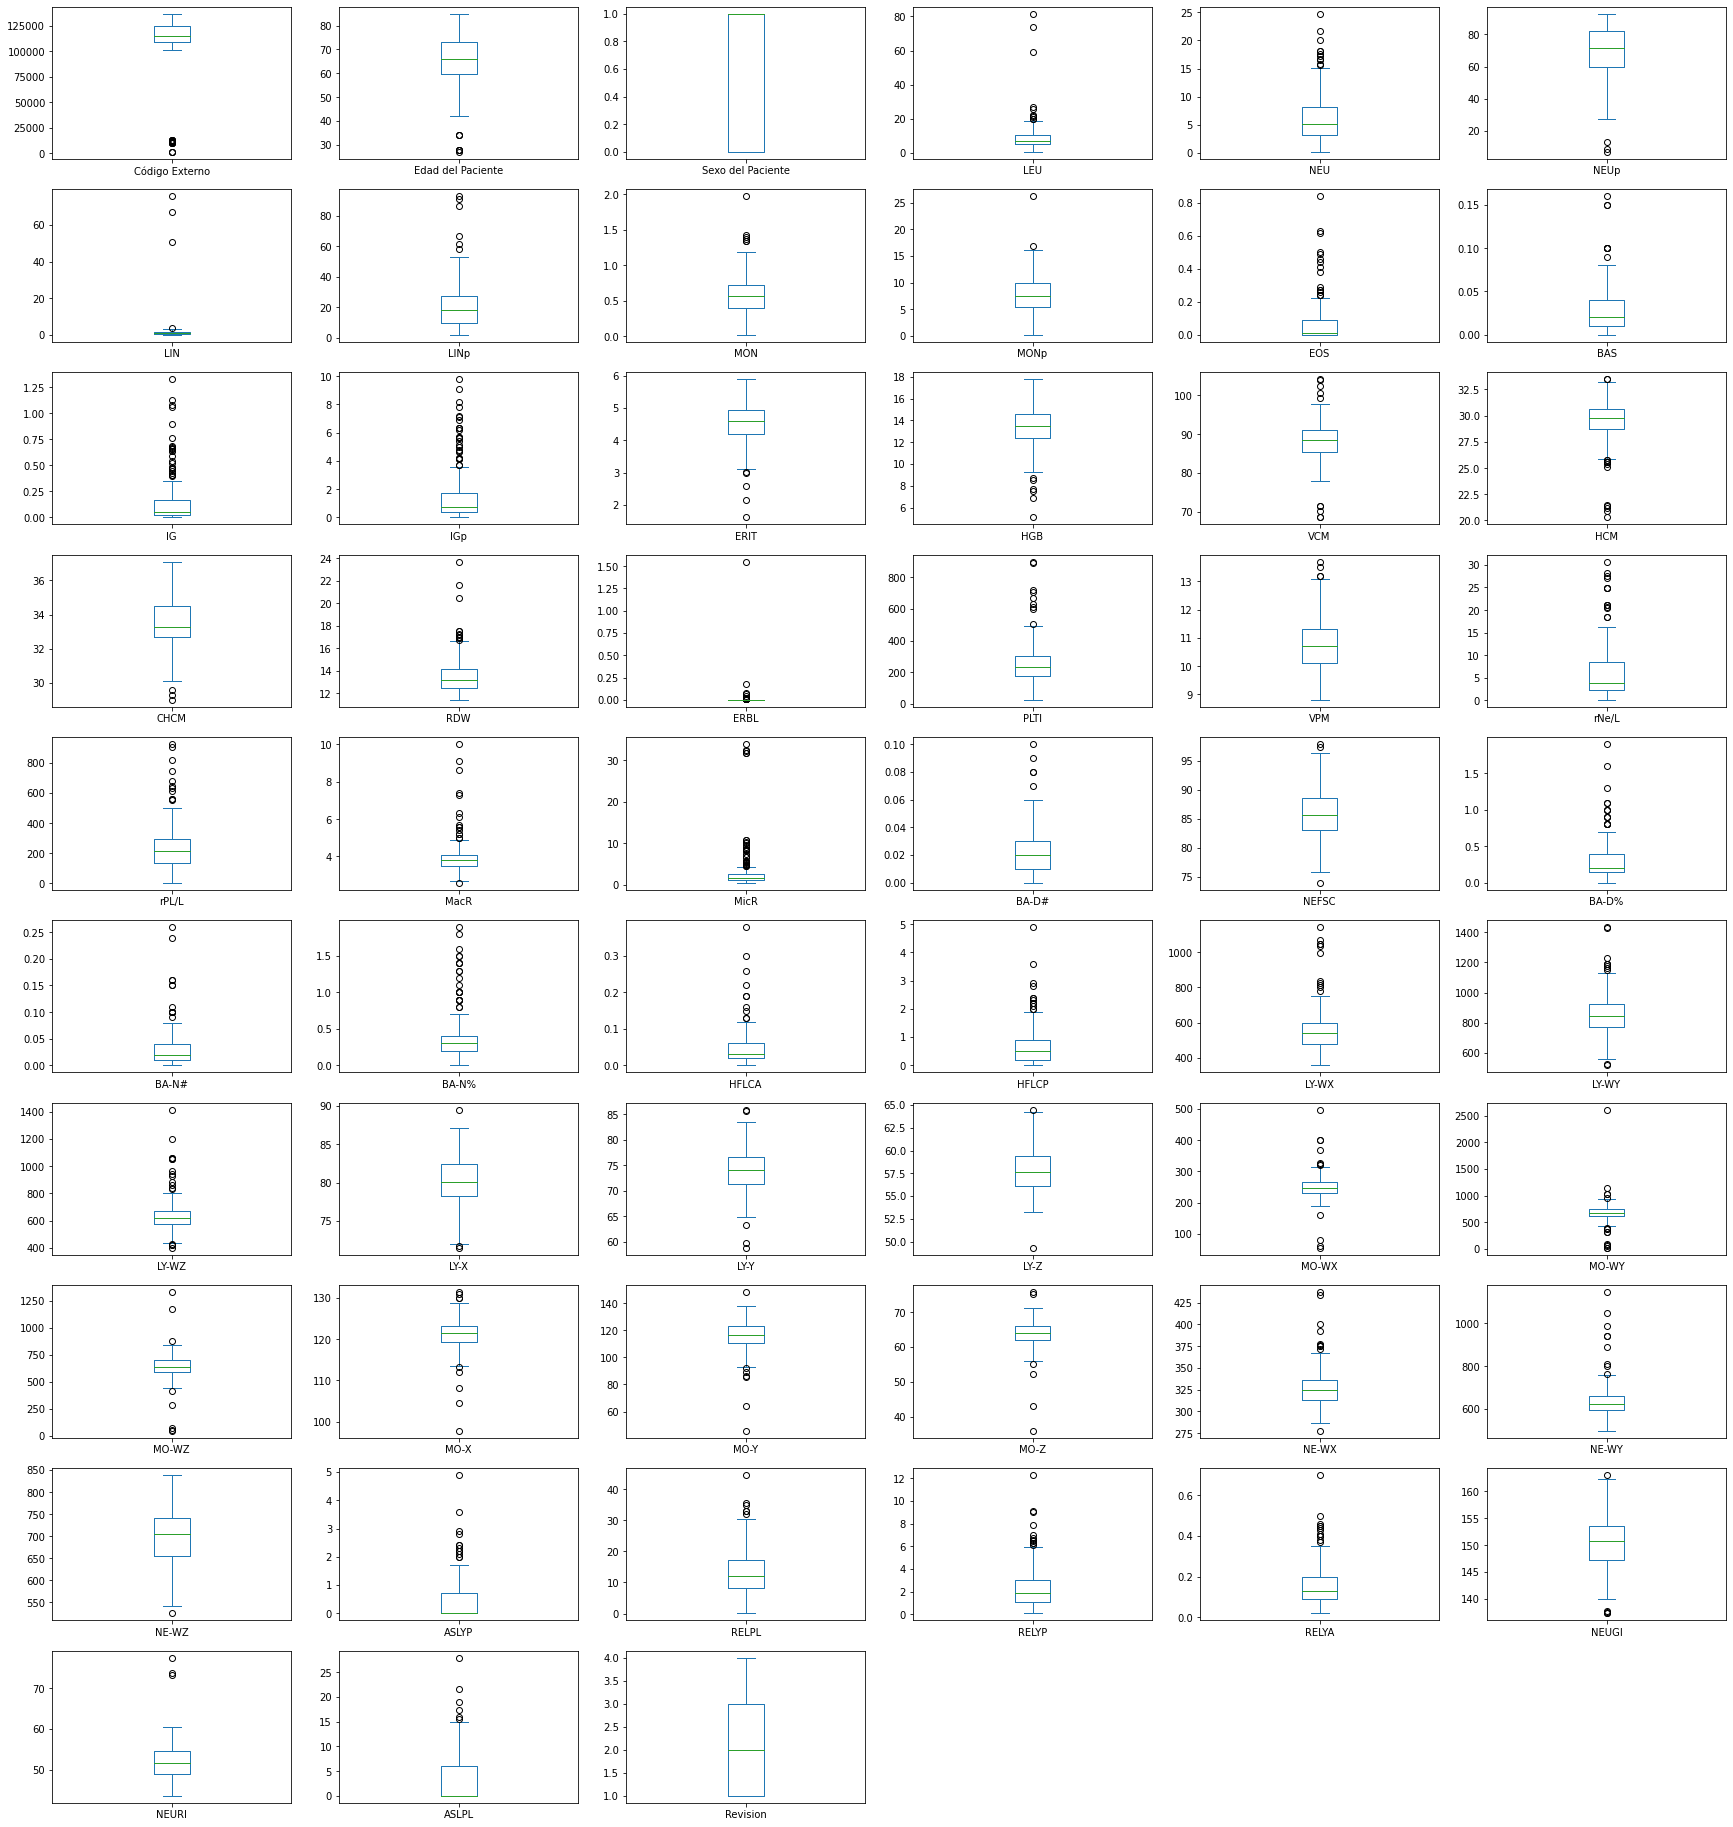

In [26]:
x_train.plot(kind='box',subplots=True, layout=(21,6), sharex=False, sharey=False, figsize=(30,70));

A continuación calculo el z-score. Cada puntuación z nos dice a cuántas desviaciones estándar se encuentra un valor individual de la media de los valores del conjunto que estoy estudiando.

Se calcula el z-score sin normalizar y comprobar si cada valor se encuentra dentro de 3 veces la desviación típica. En el caso de que se encuentren fuera de ese intervalo se le considera outlier y será reemplazado a NaN.

In [27]:
def outliers (datos,dtype): #Función z-score
    count=0
    lista=[]
    for i in dtype[datos]:
        if not (dtype[datos].mean()-3*dtype[datos].std())<=i<=(dtype[datos].mean()+3*dtype[datos].std()): # 3 veces la desviacion estandar
            if not np.isnan(i):
                count=count+1
                lista.append(i)
   
    return lista 

In [28]:
numeric_variables_train = x_train.select_dtypes(exclude=['object'])

x_train_aux = x_train.copy()

for i in numeric_variables_train:
   x_train_aux[[i]]=x_train[[i]].replace(outliers(i,x_train),np.nan) 

In [29]:
x_train_aux.shape

(255, 57)

In [30]:
for index,value in enumerate (x_train.isnull().sum()):
  if value !=0:
    print(x_train_aux.columns[index],value)

LEU 28
NEU 28
NEUp 28
LIN 28
LINp 28
MON 28
MONp 28
EOS 28
BAS 28
IG 28
IGp 28
ERIT 28
HGB 28
VCM 28
HCM 28
CHCM 28
RDW 28
ERBL 28
PLTI 29
VPM 31
rNe/L 125
rPL/L 125
MacR 28
MicR 28
BA-D# 28
NEFSC 28
BA-D% 28
BA-N# 28
BA-N% 28
HFLCA 28
HFLCP 28
LY-WX 28
LY-WY 28
LY-WZ 28
LY-X 28
LY-Y 28
LY-Z 28
MO-WX 28
MO-WY 28
MO-WZ 28
MO-X 28
MO-Y 28
MO-Z 28
NE-WX 28
NE-WY 28
NE-WZ 28
ASLYP 31
RELPL 31
RELYP 31
RELYA 31
NEUGI 28
NEURI 28
ASLPL 31


In [31]:
x_train_aux.columns

Index(['Código Externo', 'Edad del Paciente', 'Sexo del Paciente', 'LEU',
       'NEU', 'NEUp', 'LIN', 'LINp', 'MON', 'MONp', 'EOS', 'BAS', 'IG', 'IGp',
       'ERIT', 'HGB', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL', 'PLTI', 'VPM',
       'rNe/L', 'rPL/L', 'MacR', 'MicR', 'BA-D#', 'NEFSC', 'BA-D%', 'BA-N#',
       'BA-N%', 'HFLCA', 'HFLCP', 'LY-WX', 'LY-WY', 'LY-WZ', 'LY-X', 'LY-Y',
       'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X', 'MO-Y', 'MO-Z', 'NE-WX',
       'NE-WY', 'NE-WZ', 'ASLYP', 'RELPL', 'RELYP', 'RELYA', 'NEUGI', 'NEURI',
       'ASLPL', 'Revision'],
      dtype='object')

***Imputacion de valores perdidos mediante KNN Imputer***

A continuación haré uso de KNNImputer. KNNImputer es una clase de scikit-learn que se utiliza para completar o predecir los valores faltantes en un conjunto de datos. Es un método que funciona con el enfoque básico del algoritmo KNN y que se considera que proporciona una mejor rendimiento que otros enfoques, como puedes ser la imputación de los outliers por la media o la mediana.

El siguiente código tiene como fin, ayudar en la elección del número K óptimo con el que realizar la imputación de los outliers convertidos en NaN. La investigación sugiere que es imperativo probar el modelo usando validación cruzada después de realizar la imputación con diferentes valores de k. Aunque la imputación de valores perdidos es un campo de estudio en constante evolución, kNN actúa como una estrategia simple y efectiva.

Al final de la ejecución, se crea un diagrama de caja y bigotes para cada conjunto de resultados, lo que permite comparar la distribución de los valores finales.

In [32]:
x_train_aux.shape

(255, 57)

>1 0.887 (0.035)
>3 0.876 (0.032)
>5 0.866 (0.035)
>7 0.865 (0.035)
>9 0.866 (0.033)
>15 0.874 (0.035)
>18 0.871 (0.030)
>21 0.868 (0.031)
>25 0.862 (0.037)
>30 0.869 (0.032)
>36 0.875 (0.039)
>40 0.872 (0.036)


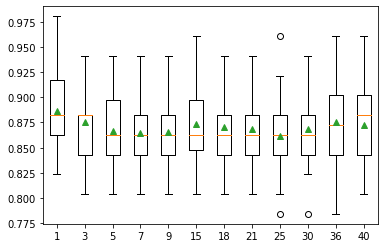

In [33]:
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# evaluate each strategy on the dataset
results = list()
strategies = [str(i) for i in [1,3,5,7,9,15,18,21,25,30,36,40]]
for s in strategies:
    # create the modeling pipeline
    
    #me parece ok usar RF
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])  ###NO SE QUE ALGORITMO UTILIZAR
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)  ###NO SE QUE NUMEROS PONER EN LOS PARAMETROS
    #Pongo X_train e y_train, ya que son los conjuntos sobre los que voy a trabajar
    scores = cross_val_score(pipeline, x_train, y_train['label'], scoring='accuracy', cv=cv, n_jobs=-1) ###NO SE QUE X E Y PONER
    # store results
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

En este caso, podemos ver que los valores de k no siguen una uniformidad a la hora de dar un rendimiento óptimo del algoritmo en cuestión. Por lo tanto, se puede observar que para un k = --- el modelo presenta el mejor rendimiento con una precisión de alrededor de --- por ciento.


**Óscar**

Si te fijas sólo en las medias (los triangulitos, se ve que enseguida saturan y se ponen a un buen nivel, así que lo que yo haría sería quderme con un ńumero relativamente pqueño, por ejemplo 5)

Por esa razón, utilizaremos dicho valor de K en KNNImputer. Además, tendremos en cuenta otros 2 parámetros. 



*   Por un lado, se tiene en cuenta la medida de distancia, la cual se puede ponderar proporcionalmente a la distancia entre instancias (filas), aunque esto se establece en una ponderación uniforme por defecto, controlada a través del argumento "weights". En este caso, se opta por darle un valor unirforme, por lo que todas las muestras tienen la misma importancia a la hora de "influenciar" a la muestra NaN.

*   Por otro lado, se encuentra el parámetro "metric", el cual hace referencia a la medida de distancia que se utilizará para calcular la distancia entre los miembros del conjunto de datos de entrenamiento. Esta vez se opta por la distancia euclidea, ya que es la distancia utilizada en algunos de los principales métodos para ajustar estimaciones estadísticas de los datos minimizando errores, como el método de mínimos cuadrados.



In [34]:
from sklearn.impute import KNNImputer
from numpy import isnan

# print total missing
print('Total missing values before imputation: %d' % x_train_aux.isnull().sum().sum())

# define imputer
imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean', weights='uniform') #Se calcula la distancia euclidea del punto NaN a los n vecinos 
                                      # mas cercanos. Además se le da un peso uniforme a todos los vecinos, es decir todos los vecinos tienen
                                      # la misma importancia.

# fit on the dataset
imputer.fit(x_train_aux)

# transform the dataset
x_train_aux = imputer.transform(x_train_aux)

# print total missing
print('Total missing values after imputation: %d' % sum(isnan(x_train_aux).flatten()))

Total missing values before imputation: 1901
Total missing values after imputation: 0


In [35]:
x_train_aux.shape

(255, 57)

In [36]:
x_train_aux = pd.DataFrame(x_train_aux) #paso X_train de numpy_array a DataFrame

#Compruebo que no queda ningún NaN en la base de datos. De esa manera ya puedo trabajar con ella.
check_for_nan = x_train.isnull().values.any()
print (check_for_nan)




True


In [37]:
x_train_aux.columns = x_train.columns

## 2.4 Identificación de outliers e imputacion de los mismos en X_test usando el método KNN Imputer




In [38]:
numeric_variables_test = x_test.select_dtypes(exclude=['object'])

for i in numeric_variables_test:
   x_test[[i]]=x_test[[i]].replace(outliers(i,x_test),np.nan) 

In [39]:
for index,value in enumerate (x_test.isnull().sum()):
  if value !=0:
    print(x_test.columns[index],value)

LEU 9
NEU 9
NEUp 8
LIN 10
LINp 8
MON 10
MONp 10
EOS 8
BAS 9
IG 9
IGp 9
ERIT 8
HGB 8
VCM 8
HCM 8
CHCM 8
RDW 8
ERBL 10
PLTI 9
VPM 12
rNe/L 36
rPL/L 36
MacR 9
MicR 10
BA-D# 8
NEFSC 9
BA-D% 8
BA-N# 10
BA-N% 9
HFLCA 10
HFLCP 9
LY-WX 8
LY-WY 9
LY-WZ 9
LY-X 8
LY-Y 8
LY-Z 8
MO-WX 9
MO-WY 8
MO-WZ 8
MO-X 8
MO-Y 8
MO-Z 8
NE-WX 9
NE-WY 9
NE-WZ 8
ASLYP 12
RELPL 14
RELYP 13
RELYA 13
NEUGI 9
NEURI 8
ASLPL 12


In [40]:
# print total missing
print('Total missing values before imputation: %d' % x_test.isnull().sum().sum())

#OJO: yo diría que esto es una mala práctica, no es malísima, pero no estás siendo justo. Lo ideal es, ahora
#que has entrenado el model en training bien (el KNNImputer), utilizar ese entrenamiento con los nuevos datos, no 
#volver a ajustar los datos. 

# define imputer
#imputer = KNNImputer(n_neighbors=21, weights='uniform', metric='nan_euclidean')


# fit on the dataset
# imputer.fit(X_test)  

# transform the dataset
x_test = imputer.transform(x_test)

# print total missing
print('Total missing values after imputation: %d' % sum(isnan(x_test).flatten()))

Total missing values before imputation: 538
Total missing values after imputation: 0


In [41]:
x_test = pd.DataFrame(x_test)

#Compruebo que no queda ningún NaN en la base de datos. De esa manera ya puedo trabajar con ella.
check_for_nan = x_test.isnull().values.any()
print (check_for_nan)

False


In [42]:
x_test.columns = x_train.columns

In [43]:
"""x_train.columns = training.columns
['Código Externo', 'Edad del Paciente', 'Sexo del Paciente', 'LEU',
       'NEU', 'NEUp', 'LIN', 'LINp', 'MON', 'MONp', 'EOS', 'EOSp', 'BAS',
       'BASp', 'IG', 'IGp', 'ERIT', 'HGB', 'HCT', 'VCM', 'HCM', 'CHCM', 'RDW',
       'ERBL', 'PLTI', 'VPM', 'rNe/L', 'rPL/L', 'MacR', 'MicR', 'BA-D#',
       'NEFSC', 'BA-D%', 'BA-N#', 'BA-N%', 'HFLCA', 'HFLCP', 'LY-WX', 'LY-WY',
       'LY-WZ', 'LY-X', 'LY-Y', 'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X',
       'MO-Y', 'MO-Z', 'NE-WX', 'NE-WY', 'NE-WZ', 'ASLYP', 'ASLYA', 'RELPL',
       'RELYP', 'RELYA', 'NEUGI', 'NEURI', 'ASLPL', 'Revision']"""

"x_train.columns = training.columns\n['Código Externo', 'Edad del Paciente', 'Sexo del Paciente', 'LEU',\n       'NEU', 'NEUp', 'LIN', 'LINp', 'MON', 'MONp', 'EOS', 'EOSp', 'BAS',\n       'BASp', 'IG', 'IGp', 'ERIT', 'HGB', 'HCT', 'VCM', 'HCM', 'CHCM', 'RDW',\n       'ERBL', 'PLTI', 'VPM', 'rNe/L', 'rPL/L', 'MacR', 'MicR', 'BA-D#',\n       'NEFSC', 'BA-D%', 'BA-N#', 'BA-N%', 'HFLCA', 'HFLCP', 'LY-WX', 'LY-WY',\n       'LY-WZ', 'LY-X', 'LY-Y', 'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X',\n       'MO-Y', 'MO-Z', 'NE-WX', 'NE-WY', 'NE-WZ', 'ASLYP', 'ASLYA', 'RELPL',\n       'RELYP', 'RELYA', 'NEUGI', 'NEURI', 'ASLPL', 'Revision']"

# 3. XGBoost

Comienzo seleccionando únicamente los parámetros que elgió el método XGBoost 

In [44]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb

In [45]:
### AHORA TENGO QUE PONER AQUI LAS VARIABLES QUE HA ELEGIDO FINALMENTE EL MODELO XGBOOST
x_train_XGB = x_train_aux[['Código Externo', 'IG','MO-Y','MicR','Revision']].copy()
x_test_XGB = x_test[['Código Externo', 'IG','MO-Y','MicR','Revision']].copy()

**Jorge** antes de comenzar a realizar la parte de regresión lineal hay que hacer exactamente lo mismo que hicimos con el dataframe original, es decir el tratamiento de outliers y la imputación. Esta parte tiene que ser exactamente igual que antes. Es decir, será necesario utilizar todas las variables, porque creo que utilizábamos KNN imputer. 

Cuando tengas todos los valores sin NaN, es cuando podremos comenzar a realizar la parte de incluir la tendencia temporal. 


Esto ya lo tienes hecho, por lo que no debería tomarte mucho tiempo. Creoq ue la secuencia de pasos debería ser:

1. no quitar las variables seleccionadas
2. incluir revisión y label
3. separar en training y test (utiliando el identificador, para que un paciente esté en training o test, pero no en ambos)
4. identificación de outliers
5. imputación de outlires con knn (exactamente el mismo esquema que has hecho antes)
6. Selección de las variables que se han elegido con xgboost.
7. Incorporar coeficintes de la regresión lineal para capturar la dinámica.

### 3.1 Búsqueda de coeficientes (REGRESION LINEAL)

Vamos a realizar un análisis de tendencias para cada variable de forma poblacional. También usaremos este análisis de tendencias de forma individual para cada paciente, de forma que se pueda incorporar la información dinámica que genera dentro del modelo de predicción basado en machine learning.

Vamos a generar la función que obtiene el modelo de regresión lineal. El modelo que planteamos es un polinomio de segundo orden:

$y = a + bx + cx^2$ ;

donde la x corresponde al número de revisión.

Ahora debo de conseguir introducir 3 coeficientes por cada una de los parámetros seleccionados por el método y por cada uno de los pacientes

In [46]:
from sklearn.linear_model import LinearRegression

def lin_reg_model(revi,x_val):
    """
    Función que ajusta un modelo de regresión lineal para el conjunto de datos que viene dado por rev y x_val. Vamos a usar
    sklearn, pero podríamos utilizar cualquier otro módulo de algebra lineal
    """
    
    #generamos la matrix X, que tiene que contener en una columna rev y en otra rev**2
    
    
    rev_2 = revi**2
    
    X = np.vstack((np.ones(revi.shape),revi,rev_2)).T #JA Como quiero un polinomio de segundo orden... meto
                      #unos que me sirven como "a", rev que me sirve como "b" y rev_2 que me sirve como "c"
    
    #ajustamos el modelo de regresion lineal
    
    #le digo false, para que me devuelva todo los coeficientes en coef_
    clf = LinearRegression(fit_intercept=False) #yo creo que lo que haría, para que fuesen todos comparables sería 
    # normalizar los datos pero no lo tengo claro, lo tendría que pensar
    
    clf.fit(X,x_val)
    
    #devolvemos los coeficientes
    return clf.coef_

In [47]:
"""
revi= np.array([1,2,3,4])
X = []

for i in cd_train:  
      df_pat = x_train.loc[x_train["Código Externo"] == i]
      
        for j in df_pat.columns.values (:,2:9):
             coef_pat = lin_reg_model(revi,df_pat)
"""
x_train_XGB["Código Externo"] = x_train_XGB["Código Externo"].astype(int)

In [48]:
x_train_XGB[x_train_XGB["Código Externo"] == 126455]
y_train

#y_train['label'][y_train['Código Externo'] == pat].values[0]

,Código Externo,label
15,108894,0
18,108894,0
54,108894,0
242,119766,0
249,119766,0
...,...,...
261,104851,1
328,116453,1
332,116453,1
336,116453,1


In [49]:
X_training = [] #final matrix with rows = one per patient, columns = variables valuest at review 1 and temporal evolution
y_training = []



#run over each codigo externo => each patient
for i,pat in enumerate(cd_train): #JA, añade un contador a cada uno de los elementos iterables,(1,4234)(2,8259)
    cols_name = []
    #print(i)
    x_aux = [] #individual row in the X matrix for a particular pat
    
    #create a mini df with for reviews
    #print(x_train_XGB["Código Externo"])
    df_pat = x_train_XGB[x_train_XGB["Código Externo"] == pat].copy()
    
    #order mini df according to Revision
    df_pat.sort_values(by=["Revision"],inplace= True) # JA, esto ya está implementado anteriormente

    #print(df_pat)
    
    #for each variable
    feat_name = df_pat.columns[1:-1] # JA, cojo las columnas de la segunda a la penúltima de tal manera que me 
                                    # quito las columnas 'Código Externo' y 'label'
    #
    #print(feat_name)
    
    for var in feat_name:
        #get the value for the first review
        var_value_1 = df_pat[var][df_pat["Revision"] == 1] # JA, cojo el valor de la primera revisión de un paciente
                                                            # de una variable en concreto
        #print(var_value_1.values)
        if var_value_1.values.size == 0:
            #there are some blank rows, we just skip them
            #print(df_pat[["Código Externo",var]])
            continue
            
        #store the value in the x_aux    
        x_aux.append(var_value_1.values[0])
        
        #create the cols_name for the first pat only
        if pat == "126455":
            cols_name.append(var)
        
        #compute the linear regression model
        
        #review values for this var
        var_review_values = df_pat[var].values
        
        #compute the actual coefficientes for the linear regresssion
        revi = np.arange(1,len(var_review_values)+1)
        
        #vamos a centrar los valores de las revisiones para evitar utilizar coeficiente de media, y sólo tener las tendencias
        coefs = lin_reg_model(revi,var_review_values-np.mean(var_review_values))
        
        """
        plt.figure()
        plt.plot(revi,var_review_values)
        xx = np.linspace(1,4,20)

        XX = np.vstack((np.ones(xx.shape),xx,xx**2)).T
        plt.plot(xx,XX.dot(coefs),'k--',label = 'real values')
        plt.xlabel(var)
        """
        
        #store coefficients
        #x_aux.append()
        #print(len(coefs))
        for c in coefs[1:]:
            x_aux.append(c)
            
        cols_name.append(var)
        #cols_name.append(var+'_1')
        cols_name.append(var+'_2')
        cols_name.append(var+'_3')
        
        
        
        #stick x_aux in X
        
    #print(len(x_aux))
    
    if len(x_aux)==0:
        continue
        
    y_aux = y_train['label'][y_train['Código Externo'] == pat].values[0]   
    
    y_training.append(y_aux)
    X_training.append(x_aux)
    

In [50]:
X_train_XGB = np.array(X_training)
y_training_XGB = np.array(y_training)

In [51]:
print(X_train_XGB.shape)

print(y_training_XGB.shape)

(72, 9)
(72,)


In [52]:
X_test = [] #final matrix with rows = one per patient, columns = variables valuest at review 1 and temporal evolution
y_testing = []

#run over each codigo externo => each patient
for i,pat in enumerate(cd_test):
    cols_name = []
    #print(i)
    x_aux = [] #individual row in the X matrix for a particular pat
    
    #create a mini df with for reviews
    #print(x_train_XGB["Código Externo"])
    df_pat = x_test_XGB[x_test_XGB["Código Externo"] == pat].copy()
    
    #order mini df according to Revision
    df_pat.sort_values(by=["Revision"],inplace= True)

    #print(df_pat)
    
    #for each variable
    feat_name = df_pat.columns[1:-1]
    #print(feat_name)
    
    for var in feat_name:
        #get the value for the first review
        var_value_1 = df_pat[var][df_pat["Revision"] == 1]
        #print(var_value_1.values)
        if var_value_1.values.size == 0:
            #there are some blank rows, we just skip them
            #print(df_pat[["Código Externo",var]])
            continue
            
        #store the value in the x_aux    
        x_aux.append(var_value_1.values[0])
        
        #create the cols_name for the first pat only
        if pat == "126455":
            cols_name.append(var)
        
        #compute the linear regression model
        
        #review values for this var
        var_review_values = df_pat[var].values
        
        #compute the actual coefficientes for the linear regresssion
        revi = np.arange(1,len(var_review_values)+1)
        coefs = lin_reg_model(revi,var_review_values-np.mean(var_review_values))
        
        """
        plt.figure()
        plt.plot(revi,var_review_values)
        xx = np.linspace(1,4,20)

        XX = np.vstack((np.ones(xx.shape),xx,xx**2)).T
        plt.plot(xx,XX.dot(coefs),'k--',label = 'real values')
        plt.xlabel(var)
        """
        
        #store coefficients
        #x_aux.append()
        #print(len(coefs))
        for c in coefs[1:]:
            x_aux.append(c)
            
        cols_name.append(var)
       # cols_name.append(var+'_1')
        cols_name.append(var+'_2')
        cols_name.append(var+'_3')
        
        
        
        #stick x_aux in X
        
    #print(len(x_aux))
    
    if len(x_aux)==0:
        continue
        
    y_aux = y_test['label'][y_test['Código Externo'] == pat].values[0]   
    
    y_testing.append(y_aux)
    X_test.append(x_aux)
    

In [53]:
X_test_XGB = np.array(X_test)
y_testing_XGB = np.array(y_testing)

print(X_test_XGB.shape)
print(y_testing_XGB.shape)

(20, 9)
(20,)


In [54]:
#Jorge ya tienes disponible X_train, y_training, X_test, y_testing para poder hacer el análisis completo

In [55]:
X_train_XGB = pd.DataFrame(X_train_XGB,columns = cols_name)
X_test_XGB = pd.DataFrame(X_test_XGB,columns = cols_name)

### 3.2 Optimización de los hiperparámetros usando RandomizedSearchCV

In [56]:
#Indico que el clasificador que voy a utlizar es XGBosst

xgb_model = xgb.XGBClassifier(use_label_encoder =False)

Inicialmente creamos un diccionario de algunos parámetros a entrenar. Aquí las claves son básicamente los parámetros y los valores a entrenar. Así que el RandomizedSearchCV probará cada valor y encontrará el valor particular que da la mayor precisión.

In [57]:
#Cuanto mayor sea gamma, más conservador será el algoritmo
#min_child_weight: para controlar el sobreajuste, cuanto mayor sea min_child_weight, más conservador será el algoritmo

params = {
 'n_estimators' : [25,50,75,100,125,150,175,200,250,300,350,400],
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [3,4,5,6,8,10,12,15],
 'gamma': [0.0,0.1,0.2,0.3,0.4],
 'colsample_bytree' : [0.3,0.4,0.5,0.7]
}



A continuación, llamamos a RandomizedSearchCV() y le pasamos los siguientes parámetros

In [58]:
y_training_XGB

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1])

In [59]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model = RandomizedSearchCV(xgb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)
r_s_model.fit(X_train_XGB, y_training_XGB)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(use_label_encoder=False),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'n_estimators': [25, 50, 75, 100, 125,
                                                         150, 175, 200, 250,
                                                         300, 350, 400]},
                   random_state=2, scoring='roc_auc', verbose=3)

Bien, nuestro modelo ha sido ajustado. Veamos ahora todos los parámetros que han sido seleccionados por el RandomizedSearch() para el XGBClassifier. Podemos hacerlo con la ayuda del método best_estimators_.

In [60]:
r_s_model.best_estimator_

XGBClassifier(colsample_bytree=0.3, gamma=0.4, learning_rate=0.15, max_depth=12,
              n_estimators=200, use_label_encoder=False)

Una vez conozco los valores de hiperparámetros, vuelvo a buscar la optimización de los mismos, pero esta vez afinando más.

In [61]:
#Cuanto mayor sea gamma, más conservador será el algoritmo
#min_child_weight: para controlar el sobreajuste, cuanto mayor sea min_child_weight, más conservador será el algoritmo

params = {
 'n_estimators' : [110,115,120,125,130,135,140,145],
 'learning_rate' : [0.19,0.21,0.23,0.25,0.27,0.29,0.31],
 'max_depth' : [1,2,3,4,5,6,7,8,9,10],
 'gamma': [0.16,0.18,0.2,0.22,0.24,0.26],
 'colsample_bytree' : [0.44,0.46,0.48,0.5,0.52,0.54,0.56]
}

In [62]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model = RandomizedSearchCV(xgb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)
r_s_model.fit(X_train_XGB, y_training_XGB)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(use_label_encoder=False),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.44, 0.46, 0.48,
                                                             0.5, 0.52, 0.54,
                                                             0.56],
                                        'gamma': [0.16, 0.18, 0.2, 0.22, 0.24,
                                                  0.26],
                                        'learning_rate': [0.19, 0.21, 0.23,
                                                          0.25, 0.27, 0.29,
                                                          0.31],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'n_estimators': [110, 115, 120, 125,
                                                         130, 135, 140, 145]},
           

In [63]:
r_s_model.best_estimator_

XGBClassifier(colsample_bytree=0.44, gamma=0.18, learning_rate=0.31,
              max_depth=8, n_estimators=125, use_label_encoder=False)

In [64]:
xgb_model.fit(X_train_XGB, y_training_XGB)

XGBClassifier(use_label_encoder=False)

## 1.4 Rendimiento con FS en el conjunto de test

In [65]:
xgb_FS = xgb.XGBClassifier(colsample_bytree=0.44, gamma=0.18, learning_rate=0.31,
              max_depth=8, n_estimators=125)
xgb_FS.fit(X_train_XGB, y_training_XGB)

XGBClassifier(colsample_bytree=0.44, gamma=0.18, learning_rate=0.31,
              max_depth=8, n_estimators=125)

In [66]:
from sklearn.metrics import roc_auc_score



#Todas las características
y_pred_tot = xgb_model.predict(X_test_XGB)
acc_tot = accuracy_score(y_testing_XGB, y_pred_tot)
sensibilidad_tot = recall_score(y_testing_XGB, y_pred_tot)
#precision_tot=precision_score(y_test, y_pred_tot)
specificity_tot = confusion_matrix(y_testing_XGB, y_pred_tot)[0][0]/(confusion_matrix(y_testing_XGB, y_pred_tot)[0][0]+confusion_matrix(y_testing_XGB, y_pred_tot)[0][1])
auc_tot = roc_auc_score(y_testing_XGB, y_pred_tot)



Tabla_xgb = pd.DataFrame({"Prestaciones en test":["Accuracy","Sensitivity",'Specificity',"AUC ROC"],
                          "XGBoost total" : [acc_tot, sensibilidad_tot, specificity_tot, auc_tot]})
Tabla_xgb

,Prestaciones en test,XGBoost total
0,Accuracy,0.900000
1,Sensitivity,0.333333
2,Specificity,1.000000
3,AUC ROC,0.666667


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'XGBoost 3 features')

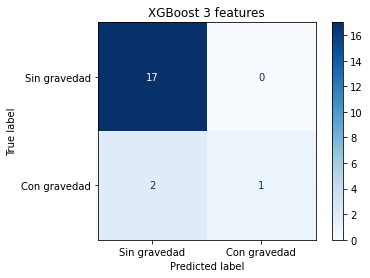

In [67]:
from sklearn.metrics import plot_confusion_matrix

#XGBoost all features
plot_confusion_matrix(xgb_model, X_test_XGB, y_testing_XGB, display_labels=["Sin gravedad","Con gravedad"],
                                 cmap=plt.cm.Blues)
plt.title("XGBoost 3 features")


tenemos muy pocos datos no sanos, así que vamos a intentar hacer un análisis de bootstrap

In [68]:
"""
import random

B = 2000
acc = []
sens = []
spe = []
auc = []
tn_t = []
fp_t = []
fn_t = []
tp_t = []
np.random.seed(1947)
for i in range(B):
    #sampling from X_test and y_testing
    print(i)
    
    idx_b = np.random.randint(len(y_testing), size=len(y_testing))
    #print(idx_b)
    X_test_B = X_test.iloc[idx_b,:]
    y_test_b = y_testing[idx_b]
    
    #Todas las características
    y_pred_b = xgb_model.predict(X_test_B)
    acc_tot = accuracy_score(y_test_b, y_pred_b)
    sensibilidad_tot = recall_score(y_test_b, y_pred_b)
    #precision_tot=precision_score(y_test, y_pred_tot)
    if len(confusion_matrix(y_test_b, y_pred_b).ravel()) == 1:
        if np.sum(y_test_b) == 0 and np.sum(y_pred_b) == 0:
            specificity_tot = 1
            tn = len(y_test_b)
            fp = 0
            fn = 0
            tp = 0
            continue
            
    tn, fp, fn, tp = confusion_matrix(y_test_b, y_pred_b).ravel()
    #print(tn,fp,fn,tp)
    #sensibilidad_tot = tp / (tp+fn)
    specificity_tot = tn / (tn+fp)
    #confusion_matrix(y_test_b, y_pred_b)[0][0]/(confusion_matrix(y_test_b, y_pred_b)[0][0]+confusion_matrix(y_test_b, y_pred_b)[0][1])
    #auc_tot = roc_auc_score(y_test_b, y_pred_b)
    
    acc.append(acc_tot)
    sens.append(sensibilidad_tot)
    spe.append(specificity_tot)
    tn_t.append(tn)
    fn_t.append(fn)
    tp_t.append(tp)
    fp_t.append(fp)
    #auc.append(auc_tot)


"""


'\nimport random\n\nB = 2000\nacc = []\nsens = []\nspe = []\nauc = []\ntn_t = []\nfp_t = []\nfn_t = []\ntp_t = []\nnp.random.seed(1947)\nfor i in range(B):\n    #sampling from X_test and y_testing\n    print(i)\n    \n    idx_b = np.random.randint(len(y_testing), size=len(y_testing))\n    #print(idx_b)\n    X_test_B = X_test.iloc[idx_b,:]\n    y_test_b = y_testing[idx_b]\n    \n    #Todas las características\n    y_pred_b = xgb_model.predict(X_test_B)\n    acc_tot = accuracy_score(y_test_b, y_pred_b)\n    sensibilidad_tot = recall_score(y_test_b, y_pred_b)\n    #precision_tot=precision_score(y_test, y_pred_tot)\n    if len(confusion_matrix(y_test_b, y_pred_b).ravel()) == 1:\n        if np.sum(y_test_b) == 0 and np.sum(y_pred_b) == 0:\n            specificity_tot = 1\n            tn = len(y_test_b)\n            fp = 0\n            fn = 0\n            tp = 0\n            continue\n            \n    tn, fp, fn, tp = confusion_matrix(y_test_b, y_pred_b).ravel()\n    #print(tn,fp,fn,tp)\n  

Tabla_xgb = pd.DataFrame({"Prestaciones en test":["Accuracy","Sensitivity",'Specificity',"AUC ROC"],
                          "XGBoost total" : [acc_tot, sensibilidad_tot, specificity_tot, auc_tot]})
Tabla_xgb 

In [69]:
"""
print(np.mean(sens),np.std(sens))

"""

'\nprint(np.mean(sens),np.std(sens))\n\n'

In [70]:
"""
import seaborn as sns

cf_matrix = [[np.mean(tn_t),np.mean(fp_t)],[np.mean(fn_t),np.mean(tp_t)]]
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

"""

"\nimport seaborn as sns\n\ncf_matrix = [[np.mean(tn_t),np.mean(fp_t)],[np.mean(fn_t),np.mean(tp_t)]]\nax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')\n\nax.set_title('Seaborn Confusion Matrix with labels\n\n');\nax.set_xlabel('\nPredicted Values')\nax.set_ylabel('Actual Values ');\n\n## Ticket labels - List must be in alphabetical order\nax.xaxis.set_ticklabels(['False','True'])\nax.yaxis.set_ticklabels(['False','True'])\n\n## Display the visualization of the Confusion Matrix.\nplt.show()\n\n"

In [71]:
"""print(tn_t)"""

'print(tn_t)'

# 3. Gradient Boosting

Comienzo seleccionando únicamente los parámetros que elgió el método GBoost

In [72]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [73]:
### AHORA TENGO QUE PONER AQUI LAS VARIABLES QUE HA ELEGIDO FINALMENTE EL MODELO GBOOST
x_train_GB = x_train_aux[['Código Externo','MO-Y', 'NEUGI','Revision']].copy()
x_test_GB = x_test[['Código Externo','MO-Y', 'NEUGI','Revision']].copy()

### 3.1 Búsqueda de coeficientes (REGRESION LINEAL)

Vamos a realizar un análisis de tendencias para cada variable de forma poblacional. También usaremos este análisis de tendencias de forma individual para cada paciente, de forma que se pueda incorporar la información dinámica que genera dentro del modelo de predicción basado en machine learning.

Vamos a generar la función que obtiene el modelo de regresión lineal. El modelo que planteamos es un polinomio de segundo orden:

$y = a + bx + cx^2$ ;

donde la x corresponde al número de revisión.

In [74]:
x_train_GB["Código Externo"] = x_train_GB["Código Externo"].astype(int)

In [75]:
X_training = [] #final matrix with rows = one per patient, columns = variables valuest at review 1 and temporal evolution
y_training = []



#run over each codigo externo => each patient
for i,pat in enumerate(cd_train): #JA, añade un contador a cada uno de los elementos iterables,(1,4234)(2,8259)
    cols_name = []
    #print(i)
    x_aux = [] #individual row in the X matrix for a particular pat
    
    #create a mini df with for reviews
    #print(x_train_XGB["Código Externo"])
    df_pat = x_train_GB[x_train_GB["Código Externo"] == pat].copy()
    
    #order mini df according to Revision
    df_pat.sort_values(by=["Revision"],inplace= True) # JA, esto ya está implementado anteriormente

    #print(df_pat)
    
    #for each variable
    feat_name = df_pat.columns[1:-1] # JA, cojo las columnas de la segunda a la penúltima de tal manera que me 
                                    # quito las columnas 'Código Externo' y 'label'
    #
    #print(feat_name)
    
    for var in feat_name:
        #get the value for the first review
        var_value_1 = df_pat[var][df_pat["Revision"] == 1] # JA, cojo el valor de la primera revisión de un paciente
                                                            # de una variable en concreto
        #print(var_value_1.values)
        if var_value_1.values.size == 0:
            #there are some blank rows, we just skip them
            #print(df_pat[["Código Externo",var]])
            continue
            
        #store the value in the x_aux    
        x_aux.append(var_value_1.values[0])
        
        #create the cols_name for the first pat only
        if pat == "126455":
            cols_name.append(var)
        
        #compute the linear regression model
        
        #review values for this var
        var_review_values = df_pat[var].values
        
        #compute the actual coefficientes for the linear regresssion
        revi = np.arange(1,len(var_review_values)+1)
        
        #vamos a centrar los valores de las revisiones para evitar utilizar coeficiente de media, y sólo tener las tendencias
        coefs = lin_reg_model(revi,var_review_values-np.mean(var_review_values))
        
        """
        plt.figure()
        plt.plot(revi,var_review_values)
        xx = np.linspace(1,4,20)

        XX = np.vstack((np.ones(xx.shape),xx,xx**2)).T
        plt.plot(xx,XX.dot(coefs),'k--',label = 'real values')
        plt.xlabel(var)
        """
        
        #store coefficients
        #x_aux.append()
        #print(len(coefs))
        for c in coefs[1:]:
            x_aux.append(c)
            
        cols_name.append(var)
        #cols_name.append(var+'_1')
        cols_name.append(var+'_2')
        cols_name.append(var+'_3')
        
        
        
        #stick x_aux in X
        
    #print(len(x_aux))
    
    if len(x_aux)==0:
        continue
        
    y_aux = y_train['label'][y_train['Código Externo'] == pat].values[0]   
    
    y_training.append(y_aux)
    X_training.append(x_aux)
    

In [76]:
X_train_GB = np.array(X_training)
y_training_GB = np.array(y_training)

In [77]:
print(X_train_GB.shape)

print(y_training_GB.shape)

(72, 6)
(72,)


In [78]:
X_test = [] #final matrix with rows = one per patient, columns = variables valuest at review 1 and temporal evolution
y_testing = []

#run over each codigo externo => each patient
for i,pat in enumerate(cd_test):
    cols_name = []
    #print(i)
    x_aux = [] #individual row in the X matrix for a particular pat
    
    #create a mini df with for reviews
    #print(x_train_XGB["Código Externo"])
    df_pat = x_test_GB[x_test_GB["Código Externo"] == pat].copy()
    
    #order mini df according to Revision
    df_pat.sort_values(by=["Revision"],inplace= True)

    #print(df_pat)
    
    #for each variable
    feat_name = df_pat.columns[1:-1]
    #print(feat_name)
    
    for var in feat_name:
        #get the value for the first review
        var_value_1 = df_pat[var][df_pat["Revision"] == 1]
        #print(var_value_1.values)
        if var_value_1.values.size == 0:
            #there are some blank rows, we just skip them
            #print(df_pat[["Código Externo",var]])
            continue
            
        #store the value in the x_aux    
        x_aux.append(var_value_1.values[0])
        
        #create the cols_name for the first pat only
        if pat == "126455":
            cols_name.append(var)
        
        #compute the linear regression model
        
        #review values for this var
        var_review_values = df_pat[var].values
        
        #compute the actual coefficientes for the linear regresssion
        revi = np.arange(1,len(var_review_values)+1)
        coefs = lin_reg_model(revi,var_review_values-np.mean(var_review_values))
        
        """
        plt.figure()
        plt.plot(revi,var_review_values)
        xx = np.linspace(1,4,20)

        XX = np.vstack((np.ones(xx.shape),xx,xx**2)).T
        plt.plot(xx,XX.dot(coefs),'k--',label = 'real values')
        plt.xlabel(var)
        """
        
        #store coefficients
        #x_aux.append()
        #print(len(coefs))
        for c in coefs[1:]:
            x_aux.append(c)
            
        cols_name.append(var)
       # cols_name.append(var+'_1')
        cols_name.append(var+'_2')
        cols_name.append(var+'_3')
        
        
        
        #stick x_aux in X
        
    #print(len(x_aux))
    
    if len(x_aux)==0:
        continue
        
    y_aux = y_test['label'][y_test['Código Externo'] == pat].values[0]   
    
    y_testing.append(y_aux)
    X_test.append(x_aux)
    

In [79]:
X_test_GB = np.array(X_test)
y_testing_GB = np.array(y_testing)

print(X_test_GB.shape)
print(y_testing_GB.shape)

(20, 6)
(20,)


In [80]:
X_train_GB = pd.DataFrame(X_train_GB,columns = cols_name)
X_test_GB = pd.DataFrame(X_test_GB,columns = cols_name)

### 3.2 Optimización de los hiperparámetros usando RandomizedSearchCV

In [81]:
#Indico que el clasificador que voy a utlizar es GBoosting

gb_model = GradientBoostingClassifier()

Inicialmente creamos un diccionario de algunos parámetros a entrenar. Aquí las claves son básicamente los parámetros y los valores a entrenar. Así que el RandomizedSearchCV probará cada valor y encontrará el valor particular que da la mayor precisión.

In [82]:
#Cuanto mayor sea gamma, más conservador será el algoritmo
#min_child_weight: para controlar el sobreajuste, cuanto mayor sea min_child_weight, más conservador será el algoritmo

params = {
 'n_estimators' : [150,200,250,300,350,400,450,500],
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [20,25,30,35,40,45],
}



In [83]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model_2 = RandomizedSearchCV(gb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)
r_s_model_2.fit(X_train_GB, y_training_GB)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [20, 25, 30, 35, 40, 45],
                                        'n_estimators': [150, 200, 250, 300,
                                                         350, 400, 450, 500]},
                   random_state=2, scoring='roc_auc', verbose=3)

Bien, nuestro modelo ha sido ajustado. Veamos ahora todos los parámetros que han sido seleccionados por el RandomizedSearch() para el GBClassifier. Podemos hacerlo con la ayuda del método best_estimators_.

In [84]:
r_s_model_2.best_estimator_

GradientBoostingClassifier(learning_rate=0.05, max_depth=20, n_estimators=500)

In [85]:
#Cuanto mayor sea gamma, más conservador será el algoritmo
#min_child_weight: para controlar el sobreajuste, cuanto mayor sea min_child_weight, más conservador será el algoritmo

params = {
 'n_estimators' : [470,480,490,500,510,520,530,540],
 'learning_rate' : [0.01,0.03,0.05,0.07,0.09],
 'max_depth' : [12,14,16,18,20,22,24,26],
}

Una vez conozco los valores de hiperparámetros, vuelvo a buscar la optimización de los mismos, pero esta vez afinando más.

In [86]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model_2 = RandomizedSearchCV(gb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)
r_s_model_2.fit(X_train_GB, y_training_GB)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.03, 0.05,
                                                          0.07, 0.09],
                                        'max_depth': [12, 14, 16, 18, 20, 22,
                                                      24, 26],
                                        'n_estimators': [470, 480, 490, 500,
                                                         510, 520, 530, 540]},
                   random_state=2, scoring='roc_auc', verbose=3)

In [87]:
r_s_model_2.best_estimator_

GradientBoostingClassifier(learning_rate=0.03, max_depth=12, n_estimators=480)

In [88]:
gb_model.fit(X_train_GB, y_training_GB)

GradientBoostingClassifier()

## 1.4 Rendimiento con FS en el conjunto de test

In [89]:
gb_FS = GradientBoostingClassifier(learning_rate=0.03, max_depth=12, n_estimators=480)
gb_FS.fit(X_train_GB, y_training_GB)

GradientBoostingClassifier(learning_rate=0.03, max_depth=12, n_estimators=480)

In [90]:
from sklearn.metrics import roc_auc_score



#Todas las características
y_pred_tot = gb_model.predict(X_test_GB)
acc_tot = accuracy_score(y_testing_GB, y_pred_tot)
sensibilidad_tot = recall_score(y_testing_GB, y_pred_tot)
#precision_tot=precision_score(y_test, y_pred_tot)
specificity_tot = confusion_matrix(y_testing_GB, y_pred_tot)[0][0]/(confusion_matrix(y_testing_GB, y_pred_tot)[0][0]+confusion_matrix(y_testing_GB, y_pred_tot)[0][1])
auc_tot = roc_auc_score(y_testing_GB, y_pred_tot)



Tabla_gb = pd.DataFrame({"Prestaciones en test":["Accuracy","Sensitivity",'Specificity',"AUC ROC"],
                          "GBoost total" : [acc_tot, sensibilidad_tot, specificity_tot, auc_tot]})
Tabla_gb

,Prestaciones en test,GBoost total
0,Accuracy,0.800000
1,Sensitivity,0.000000
2,Specificity,0.941176
3,AUC ROC,0.470588


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'GBoost 2 features')

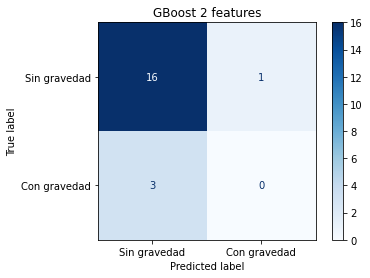

In [91]:
from sklearn.metrics import plot_confusion_matrix

#XGBoost all features
plot_confusion_matrix(gb_model, X_test_GB, y_testing_GB, display_labels=["Sin gravedad","Con gravedad"],
                                 cmap=plt.cm.Blues)
plt.title("GBoost 2 features")


# 4. Histogram-based Gradient Boosting Classifier

In [92]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import load_iris

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [93]:
### AHORA TENGO QUE PONER AQUI LAS VARIABLES QUE HA ELEGIDO FINALMENTE EL MODELO HGBOOST
x_train_HB = x_train_aux[['Código Externo','MO-Z','NEU','NEUp','IG','BA-D%','MicR','RELYP','HGB','NE-WY','Revision']].copy()
x_test_HB = x_test[['Código Externo','MO-Z','NEU','NEUp','IG','BA-D%','MicR','RELYP','HGB','NE-WY','Revision']].copy()

### 3.1 Búsqueda de coeficientes (REGRESION LINEAL)

Vamos a realizar un análisis de tendencias para cada variable de forma poblacional. También usaremos este análisis de tendencias de forma individual para cada paciente, de forma que se pueda incorporar la información dinámica que genera dentro del modelo de predicción basado en machine learning.

Vamos a generar la función que obtiene el modelo de regresión lineal. El modelo que planteamos es un polinomio de segundo orden:

$y = a + bx + cx^2$ ;

donde la x corresponde al número de revisión.

In [94]:
X_training = [] #final matrix with rows = one per patient, columns = variables valuest at review 1 and temporal evolution
y_training = []



#run over each codigo externo => each patient
for i,pat in enumerate(cd_train): #JA, añade un contador a cada uno de los elementos iterables,(1,4234)(2,8259)
    cols_name = []
    #print(i)
    x_aux = [] #individual row in the X matrix for a particular pat
    
    #create a mini df with for reviews
    #print(x_train_XGB["Código Externo"])
    df_pat = x_train_HB[x_train_HB["Código Externo"] == pat].copy()
    
    #order mini df according to Revision
    df_pat.sort_values(by=["Revision"],inplace= True) # JA, esto ya está implementado anteriormente

    #print(df_pat)
    
    #for each variable
    feat_name = df_pat.columns[1:-1] # JA, cojo las columnas de la segunda a la penúltima de tal manera que me 
                                    # quito las columnas 'Código Externo' y 'label'
    #
    #print(feat_name)
    
    for var in feat_name:
        #get the value for the first review
        var_value_1 = df_pat[var][df_pat["Revision"] == 1] # JA, cojo el valor de la primera revisión de un paciente
                                                            # de una variable en concreto
        #print(var_value_1.values)
        if var_value_1.values.size == 0:
            #there are some blank rows, we just skip them
            #print(df_pat[["Código Externo",var]])
            continue
            
        #store the value in the x_aux    
        x_aux.append(var_value_1.values[0])
        
        #create the cols_name for the first pat only
        if pat == "126455":
            cols_name.append(var)
        
        #compute the linear regression model
        
        #review values for this var
        var_review_values = df_pat[var].values
        
        #compute the actual coefficientes for the linear regresssion
        revi = np.arange(1,len(var_review_values)+1)
        
        #vamos a centrar los valores de las revisiones para evitar utilizar coeficiente de media, y sólo tener las tendencias
        coefs = lin_reg_model(revi,var_review_values-np.mean(var_review_values))
        
        """
        plt.figure()
        plt.plot(revi,var_review_values)
        xx = np.linspace(1,4,20)

        XX = np.vstack((np.ones(xx.shape),xx,xx**2)).T
        plt.plot(xx,XX.dot(coefs),'k--',label = 'real values')
        plt.xlabel(var)
        """
        
        #store coefficients
        #x_aux.append()
        #print(len(coefs))
        for c in coefs[1:]:
            x_aux.append(c)
            
        cols_name.append(var)
        #cols_name.append(var+'_1')
        cols_name.append(var+'_2')
        cols_name.append(var+'_3')
        
        
        
        #stick x_aux in X
        
    #print(len(x_aux))
    
    if len(x_aux)==0:
        continue
        
    y_aux = y_train['label'][y_train['Código Externo'] == pat].values[0]   
    
    y_training.append(y_aux)
    X_training.append(x_aux)
    

In [95]:
X_train_HB = np.array(X_training)
y_training_HB = np.array(y_training)

In [96]:
print(X_train_HB.shape)

print(y_training_HB.shape)

(72, 27)
(72,)


In [97]:
X_test = [] #final matrix with rows = one per patient, columns = variables valuest at review 1 and temporal evolution
y_testing = []

#run over each codigo externo => each patient
for i,pat in enumerate(cd_test):
    cols_name = []
    #print(i)
    x_aux = [] #individual row in the X matrix for a particular pat
    
    #create a mini df with for reviews
    #print(x_train_XGB["Código Externo"])
    df_pat = x_test_HB[x_test_HB["Código Externo"] == pat].copy()
    
    #order mini df according to Revision
    df_pat.sort_values(by=["Revision"],inplace= True)

    #print(df_pat)
    
    #for each variable
    feat_name = df_pat.columns[1:-1]
    #print(feat_name)
    
    for var in feat_name:
        #get the value for the first review
        var_value_1 = df_pat[var][df_pat["Revision"] == 1]
        #print(var_value_1.values)
        if var_value_1.values.size == 0:
            #there are some blank rows, we just skip them
            #print(df_pat[["Código Externo",var]])
            continue
            
        #store the value in the x_aux    
        x_aux.append(var_value_1.values[0])
        
        #create the cols_name for the first pat only
        if pat == "126455":
            cols_name.append(var)
        
        #compute the linear regression model
        
        #review values for this var
        var_review_values = df_pat[var].values
        
        #compute the actual coefficientes for the linear regresssion
        revi = np.arange(1,len(var_review_values)+1)
        coefs = lin_reg_model(revi,var_review_values-np.mean(var_review_values))
        
        """
        plt.figure()
        plt.plot(revi,var_review_values)
        xx = np.linspace(1,4,20)

        XX = np.vstack((np.ones(xx.shape),xx,xx**2)).T
        plt.plot(xx,XX.dot(coefs),'k--',label = 'real values')
        plt.xlabel(var)
        """
        
        #store coefficients
        #x_aux.append()
        #print(len(coefs))
        for c in coefs[1:]:
            x_aux.append(c)
            
        cols_name.append(var)
       # cols_name.append(var+'_1')
        cols_name.append(var+'_2')
        cols_name.append(var+'_3')
        
        
        
        #stick x_aux in X
        
    #print(len(x_aux))
    
    if len(x_aux)==0:
        continue
        
    y_aux = y_test['label'][y_test['Código Externo'] == pat].values[0]   
    
    y_testing.append(y_aux)
    X_test.append(x_aux)
    

In [98]:
X_test_HB = np.array(X_test)
y_testing_HB = np.array(y_testing)

print(X_test_HB.shape)
print(y_testing_HB.shape)

(20, 27)
(20,)


In [99]:
X_train_HB = pd.DataFrame(X_train_HB,columns = cols_name)
X_test_HB = pd.DataFrame(X_test_HB,columns = cols_name)

### 3.2 Optimización de los hiperparámetros usando RandomizedSearchCV

In [100]:
#Indico que el clasificador que voy a utlizar es HBoosting

hb_model = HistGradientBoostingClassifier()

Inicialmente creamos un diccionario de algunos parámetros a entrenar. Aquí las claves son básicamente los parámetros y los valores a entrenar. Así que el RandomizedSearchCV probará cada valor y encontrará el valor particular que da la mayor precisión.

In [101]:
#Cuanto mayor sea gamma, más conservador será el algoritmo
#min_child_weight: para controlar el sobreajuste, cuanto mayor sea min_child_weight, más conservador será el algoritmo

params = {
 'max_leaf_nodes': [1,3,5,7,10,13,15,20,25,30,35,40],
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [3,4,5,6,8,10,12,15,20,25,30],
}



In [102]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model_3 = RandomizedSearchCV(hb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)
r_s_model_3.fit(X_train_HB, y_training_HB)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 524, in fit
    n_threads=n_threads,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_hist_gradient_boosting/grower.py", line 214, in __init__
    min_hessian_to_split,
  File "/usr/local/

RandomizedSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12, 15,
                                                      20, 25, 30],
                                        'max_leaf_nodes': [1, 3, 5, 7, 10, 13,
                                                           15, 20, 25, 30, 35,
                                                           40]},
                   random_state=2, scoring='roc_auc', verbose=3)

Bien, nuestro modelo ha sido ajustado. Veamos ahora todos los parámetros que han sido seleccionados por el RandomizedSearch() para el GBClassifier. Podemos hacerlo con la ayuda del método best_estimators_.

In [103]:
r_s_model_3.best_estimator_

HistGradientBoostingClassifier(learning_rate=0.2, max_depth=30,
                               max_leaf_nodes=40)

In [104]:
#Cuanto mayor sea gamma, más conservador será el algoritmo
#min_child_weight: para controlar el sobreajuste, cuanto mayor sea min_child_weight, más conservador será el algoritmo

params = {
'max_leaf_nodes': [36,38,40,42,44,46],
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [26,28,30,32,34,36],
}

Una vez conozco los valores de hiperparámetros, vuelvo a buscar la optimización de los mismos, pero esta vez afinando más.

In [105]:
#verbose = genera mensajes durante el entramiento del modelo 'Fitting 5 folds...'

#roc_auc = curva AUC-ROC es la métrica de selección del modelo para el problema de clasificación 
#de dos clases múltiples.ROC nos dice qué tan bueno es el modelo para distinguir las clases dadas, 
#en términos de la probabilidad predicha.

#n_jobs = número de nucleos que se utilizan (-1 quiere decir que se utilizan todos)

r_s_model_3 = RandomizedSearchCV(hb_model , param_distributions=params, n_iter=5, 
                               scoring='roc_auc',n_jobs=-1,cv=5,verbose=3,random_state = 2)
r_s_model_3.fit(X_train_HB, y_training_HB)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [26, 28, 30, 32, 34, 36],
                                        'max_leaf_nodes': [36, 38, 40, 42, 44,
                                                           46]},
                   random_state=2, scoring='roc_auc', verbose=3)

In [106]:
r_s_model_3.best_estimator_

HistGradientBoostingClassifier(learning_rate=0.25, max_depth=32,
                               max_leaf_nodes=44)

In [107]:
hb_model.fit(X_train_HB, y_training_HB)

HistGradientBoostingClassifier()

## 1.4 Rendimiento con FS en el conjunto de test

In [108]:
hb_FS = HistGradientBoostingClassifier(learning_rate=0.25, max_depth=32, max_leaf_nodes=44)
hb_FS.fit(X_train_HB, y_training_HB)

HistGradientBoostingClassifier(learning_rate=0.25, max_depth=32,
                               max_leaf_nodes=44)

In [109]:
from sklearn.metrics import roc_auc_score



#Todas las características
y_pred_tot = hb_model.predict(X_test_HB)
acc_tot = accuracy_score(y_testing_HB, y_pred_tot)
sensibilidad_tot = recall_score(y_testing_HB, y_pred_tot)
#precision_tot=precision_score(y_test, y_pred_tot)
specificity_tot = confusion_matrix(y_testing_HB, y_pred_tot)[0][0]/(confusion_matrix(y_testing_HB, y_pred_tot)[0][0]+confusion_matrix(y_testing_HB, y_pred_tot)[0][1])
auc_tot = roc_auc_score(y_testing_HB, y_pred_tot)



Tabla_hb = pd.DataFrame({"Prestaciones en test":["Accuracy","Sensitivity",'Specificity',"AUC ROC"],
                          "HBoost total" : [acc_tot, sensibilidad_tot, specificity_tot, auc_tot]})
Tabla_hb

,Prestaciones en test,HBoost total
0,Accuracy,0.750000
1,Sensitivity,0.333333
2,Specificity,0.823529
3,AUC ROC,0.578431


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'HBGBoost 9 features')

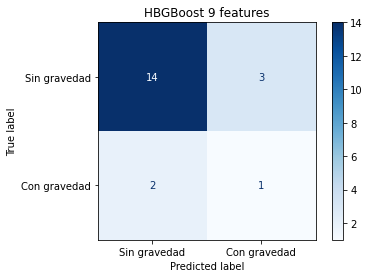

In [110]:
from sklearn.metrics import plot_confusion_matrix

#HBoost all features
plot_confusion_matrix(hb_model, X_test_HB, y_testing_HB, display_labels=["Sin gravedad","Con gravedad"],
                                 cmap=plt.cm.Blues)
plt.title("HBGBoost 9 features")
